In [2]:
import os
from google.colab import drive

# 1. Drive'ı Bağla (Zaten bağlıysa hata vermez)
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Zip yolunu kontrol et (Görseldeki isme göre)
zip_path = "/content/drive/MyDrive/Ara Proje/dataset_b.zip"
extract_path = "/content/udiat_data"

if os.path.exists(zip_path):
    !unzip -q "{zip_path}" -d "{extract_path}"
    print("✅ UDIAT verisi açıldı.")
else:
    print("❌ Dosya bulunamadı!")

✅ UDIAT verisi açıldı.


In [7]:
import os
for root, dirs, files in os.walk("/content/udiat_data"):
    if "benign" in dirs or "malignant" in dirs:
        print(f"✅ DOĞRU YOL BURASI: {root}")

✅ DOĞRU YOL BURASI: /content/udiat_data/dataset_b


In [5]:
for root, dirs, files in os.walk(extract_path):
    images = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if images:
        print(f"Klasör: {os.path.basename(root)} | Resim Sayısı: {len(images)}")

Klasör: benign | Resim Sayısı: 109
Klasör: malignant | Resim Sayısı: 54


In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# ✅ Tespit ettiğimiz doğru yol
DATA_PATH = "/content/udiat_data/dataset_b"

# 1. VERİ YÜKLEYİCİ (Augmentation YOK, Sadece 1./255)
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(
    DATA_PATH,
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    DATA_PATH,
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# 2. MODEL ADAPTASYONU (3 Sınıftan 2 Sınıfa Geçiş)
# Orijinal %86'lık ana modeli yüklüyoruz
base_model = load_model("/content/drive/MyDrive/nasnet_source_model.keras")

# Son katmanı 2 sınıfa göre (Benign/Malignant) yeniden oluşturuyoruz
x = base_model.layers[-2].output
new_output = Dense(2, activation='softmax', name='udiat_output')(x)
model_udiat = Model(inputs=base_model.input, outputs=new_output)

# Son 30 katmanı eğitime açıyoruz
for layer in model_udiat.layers[:-30]:
    layer.trainable = False

model_udiat.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 3. EĞİTİM
print("\n--- UDIAT (2 Sınıf - Saf) Fine-Tuning Başlıyor ---")
history = model_udiat.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15
)

# 4. KAYDET
save_path = "/content/drive/MyDrive/nasnet_udiat_pure.keras"
model_udiat.save(save_path)
print(f"\n✅ UDIAT Saf Model Kaydedildi: {save_path}")

Found 132 images belonging to 2 classes.
Found 31 images belonging to 2 classes.

--- UDIAT (2 Sınıf - Saf) Fine-Tuning Başlıyor ---
Epoch 1/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 178s 7s/step - accuracy: 0.6300 - loss: 0.6414 - val_accuracy: 0.6774 - val_loss: 0.6082
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.5986 - loss: 0.6349 - val_accuracy: 0.6774 - val_loss: 0.5979
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.6970 - loss: 0.5816 - val_accuracy: 0.6774 - val_loss: 0.5910
Epoch 4/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7173 - loss: 0.5515 - val_accuracy: 0.6774 - val_loss: 0.5863
Epoch 5/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.7100 - loss: 0.5610 - val_accuracy: 0.6774 - val_loss: 0.5831
Epoch 6/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.7019 - loss: 0.5269 - val_accuracy: 0.6774 - val_loss: 0.5802
Epoch 7/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.7160 - loss: 0.5279 - val_accuracy: 0.67


--- UDIAT Test Seti Tahminleri Hesaplanıyor ---
4/4 ━━━━━━━━━━━━━━━━━━━━ 59s 10s/step


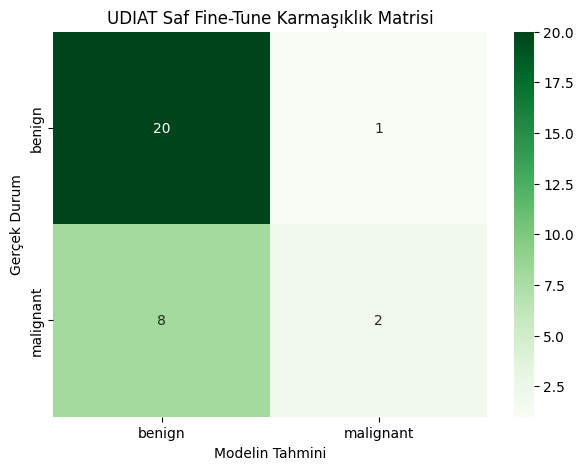


--- UDIAT Sınıflandırma Raporu ---
              precision    recall  f1-score   support

      benign       0.71      0.95      0.82        21
   malignant       0.67      0.20      0.31        10

    accuracy                           0.71        31
   macro avg       0.69      0.58      0.56        31
weighted avg       0.70      0.71      0.65        31

-------------------------------------------
UDIAT Saf (No Aug) Test Accuracy: %70.97
-------------------------------------------


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1. Tahminleri Al
print("\n--- UDIAT Test Seti Tahminleri Hesaplanıyor ---")
Y_pred = model_udiat.predict(val_gen)
y_pred = np.argmax(Y_pred, axis=1) # En yüksek olasılıklı sınıf (0 veya 1)
y_true = val_gen.classes # Gerçek sınıflar (benign=0, malignant=1)

# Sınıf isimlerini alalım
class_names = list(val_gen.class_indices.keys())

# 2. Karmaşıklık Matrisi (Confusion Matrix)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names)
plt.title('UDIAT Saf Fine-Tune Karmaşıklık Matrisi')
plt.ylabel('Gerçek Durum')
plt.xlabel('Modelin Tahmini')
plt.show()

# 3. Detaylı Metrik Raporu
print("\n--- UDIAT Sınıflandırma Raporu ---")
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

# 4. Genel Özet
final_acc = accuracy_score(y_true, y_pred)
print(f"-------------------------------------------")
print(f"UDIAT Saf (No Aug) Test Accuracy: %{final_acc*100:.2f}")
print(f"-------------------------------------------")